In [118]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
import os, re, pickle
import pandas as pd
import financial.data as fd
from financial.io.file.cache import FileCache
from financial.io.cache import NoUpdateStrategy

In [120]:
lookahead = 20
ds = fd.CachedDataStore(path=os.environ["DATA"], cache=FileCache(cache_path=os.environ["CACHE"]+"/", update_strategy=NoUpdateStrategy()))

In [121]:
ticker = "AAPL"
prediction_path = os.path.join(cache_path, f"model-momentum-svr_{ticker}_2025@pred")
series = pd.read_pickle(prediction_path)
print(series)

Date
1990-06-08    0.032258
1990-06-11    0.031442
1990-06-12    0.028463
1990-06-13    0.038756
1990-06-14    0.046439
                ...   
2025-05-23   -0.001055
2025-05-27    0.000243
2025-05-28    0.003825
2025-05-29   -0.014486
2025-05-30   -0.018013
Length: 8809, dtype: float64


In [122]:
start, end = str(series.index.min().date()), str(series.index.max().date())
p = ds.get_data(ticker, start, end)
print(p)

Date
1990-06-08      0.270132
1990-06-11      0.275428
1990-06-12      0.286021
1990-06-13      0.280725
1990-06-14      0.280725
                 ...    
2025-05-23    195.270004
2025-05-27    200.210007
2025-05-28    200.419998
2025-05-29    199.949997
2025-05-30    200.850006
Name: AAPL, Length: 8809, dtype: float64


In [123]:
start = str(series.index.min().date())
end   = str(series.index.max().date())
p = ds.get_data(ticker, start, end)

r_T = (series.astype(float) / p.astype(float).shift(lookahead)) - 1.0
r_t = r_T.shift(-lookahead).dropna()
print(r_t)

Date
1990-06-08   -0.896462
1990-06-11   -0.871698
1990-06-12   -0.848313
1990-06-13   -0.867081
1990-06-14   -0.835494
                ...   
2025-04-25   -1.000005
2025-04-28   -0.999999
2025-04-29   -0.999982
2025-04-30   -1.000068
2025-05-01   -1.000085
Length: 8789, dtype: float64


In [124]:
LOOKAHEAD = 20  # tu L fijo
CACHE = os.environ["CACHE"].rstrip("/") + "/"
DATA  = os.environ["DATA"]

def list_pred_files(cache_dir: str):
    return [
        f for f in os.listdir(cache_dir)
        if f.startswith("model-momentum-") and f.endswith("@pred")
    ]

def extract_ticker(model_filename: str) -> str | None:
    """
    model-momentum-{model}_{TICKER}_loquesea@pred
                       ^^^^^   ^^^^^^
                      parts[0] parts[1]
    """
    middle = model_filename[len("model-momentum-") : -len("@pred")]
    parts = middle.split("_")
    return parts[1] if len(parts) >= 2 else None

def convert_file(ds: fd.DataStore, cache_dir: str, fname: str):
    ticker = extract_ticker(fname)
    if not ticker:
        print(f"[SKIP] No pude extraer ticker: {fname}")
        return

    path = os.path.join(cache_dir, fname)
    with open(path, "rb") as f:
        yhat_abs = pickle.load(f)                 # Serie absoluta indexada en T (= t+L)

    if not isinstance(yhat_abs, pd.Series) or yhat_abs.empty:
        print(f"[SKIP] Formato inesperado o vacío: {fname}")
        return

    # Precios reales P_T para el rango necesario
    start = str(yhat_abs.index.min().date())
    end   = str(yhat_abs.index.max().date())
    ds_prices = ds.get_data(ticker, start, end)   # Serie de precios P_T

    # r_T = \hat P_T / P_{T-L} - 1    ->    r_t = shift(-L, r_T)
    r_T = (yhat_abs.astype(float) / ds_prices.astype(float).shift(LOOKAHEAD)) - 1.0
    r_t = r_T.shift(-LOOKAHEAD).dropna()

    # Backup del absoluto y escritura del relativo
    abs_path = path.replace("@pred", "@pred_abs")
    if not os.path.exists(abs_path):
        with open(abs_path, "wb") as f:
            pickle.dump(yhat_abs.dropna(), f)

    with open(path, "wb") as f:
        pickle.dump(r_t, f)

    # Log mínimo útil
    last_src = yhat_abs.index.max().date()
    last_rel = r_t.index.max().date() if len(r_t) else None
    print(f"[OK] {fname} | {ticker} | {len(yhat_abs)}→{len(r_t)} pts | last_src={last_src} → last_rel={last_rel}")


In [125]:
ds = fd.CachedDataStore(path=DATA, cache=FileCache(cache_path=CACHE, update_strategy=NoUpdateStrategy()))
#for fname in sorted(list_pred_files(CACHE)):
#    try:
#        convert_file(ds, CACHE, fname)
#    except Exception as e:
#       print(f"[ERR] {fname}: {e}")

In [126]:
ticker = "BAM"
prediction_path = os.path.join(cache_path, f"model-momentum-cnn_{ticker}_2025_single@pred")
series = pd.read_pickle(prediction_path)
series = series.replace(0.0, np.nan).ffill()
print(series)

Date
1990-06-08    0.021014
1990-06-11    0.022707
1990-06-12    0.024914
1990-06-13    0.023961
1990-06-14    0.024242
                ...   
2025-05-23   -0.052919
2025-05-27   -0.047559
2025-05-28   -0.054939
2025-05-29   -0.055581
2025-05-30   -0.054287
Length: 8809, dtype: float64


## Trying

In [127]:
# Importing factories:
from financial.lab import experiment
from financial.momentum.models.kerasAdvanced import KerasAdvancedModelFactory
from financial.momentum.models.randomForest import RandomForestModelFactory
from financial.momentum.models.SVR import SVRModelFactory
from financial.momentum.models.exponentialRegression import ExponentialRegressionModelFactory
from financial.momentum.experiment.modelExperiment import ModelExperimentFactory

# Importing utilities:
from financial.momentum.utilities import find_dotenv, metrics, send_telegram_message, reset_gpu, store_results

import os
from dotenv import load_dotenv

# Importing financial:
import financial.data as fd
from financial.model import Model
from financial.io.file.cache import FileCache
from financial.io.cache import NoUpdateStrategy

In [128]:
ticker = "AAPL"
load_dotenv(dotenv_path=find_dotenv())
datastore = fd.CachedDataStore(path=os.environ["DATA"], cache=FileCache(cache_path=os.environ["CACHE"]+"/", update_strategy=NoUpdateStrategy()))
start_date = "2005-01-01"
end_date = "2025-06-30"
lookahead = 20
horizon = 90
target = ds.get_data(ticker, start_date, end_date)
name = f"NEWscikit-learn_randomforest_{ticker}_{end_date[:4]}"
factory = RandomForestModelFactory()
config = {
    "mode": "global",
    "datastore": datastore,
    "ticker": ticker,
    "model_factory": factory,
    "name": name,
    "start_year": start_date,
    "end_year": end_date,
    "lookahead": 20,
    "horizon": 90,
}
try:
    #print(f"config: {config}")
    experiment = ModelExperimentFactory.create_experiment(config)
    experiment.run()
    preds = experiment.reconstruct_absolute_predictions_from_relative()
    #store_results(ticker, name, preds, experiment.predictions, os.environ["CACHE"], os.environ["MODEL"])
    #send_telegram_message("Resultados guardados")
    metrics(experiment, preds, target, os.environ["MODEL"])
    #send_telegram_message("Metricas guardadas")
except Exception as e:
    print(f"Falló el modelo {name}: {e}")

Predicciones:
Date
2019-01-02   -0.027291
2019-01-03    0.035106
2019-01-04   -0.007893
2019-01-07   -0.004572
2019-01-08   -0.017948
                ...   
2025-06-24   -0.061000
2025-06-25   -0.045237
2025-06-26   -0.029704
2025-06-27   -0.028246
2025-06-30   -0.052682
Name: AAPL, Length: 1632, dtype: float64
Test and train metrics are being saved.
TRAIN: 
n=24378 MSE=0.0007 RMSE=0.0274 MAE=0.0184 MAPE=0.6635
TEST: 
n=6012 MSE=0.0070 RMSE=0.0835 MAE=0.0645 MAPE=2.0593

Métricas guardadas exitosamente en: /home/manidmt/TFG/OTRI/models/keras/NEWscikit-learn_randomforest_AAPL_2025_metrics.json


In [129]:
print(experiment.predictions)
print(preds)

Date
2019-01-02   -0.027291
2019-01-03    0.035106
2019-01-04   -0.007893
2019-01-07   -0.004572
2019-01-08   -0.017948
                ...   
2025-06-24   -0.061000
2025-06-25   -0.045237
2025-06-26   -0.029704
2025-06-27   -0.028246
2025-06-30   -0.052682
Name: AAPL, Length: 1632, dtype: float64
Date
2019-01-31     38.673295
2019-02-01     32.722089
2019-02-04     35.597733
2019-02-05     35.400002
2019-02-06     36.566190
                 ...    
2025-06-24    197.492781
2025-06-25    203.934875
2025-06-26    204.231961
2025-06-27    204.002342
2025-06-30    198.455488
Name: AAPL, Length: 1612, dtype: float64


In [130]:
print(experiment.test)
data = ds.get_data(ticker, start_date, end_date)
print(data)

NEWscikit-learn_randomforest_AAPL_2025.AAPL.test experiments=6 n=6012
Date
2005-01-03      0.951065
2005-01-04      0.960832
2005-01-05      0.969248
2005-01-06      0.969999
2005-01-07      1.040626
                 ...    
2025-06-24    200.300003
2025-06-25    201.559998
2025-06-26    201.000000
2025-06-27    201.080002
2025-06-30    205.169998
Name: AAPL, Length: 5155, dtype: float64


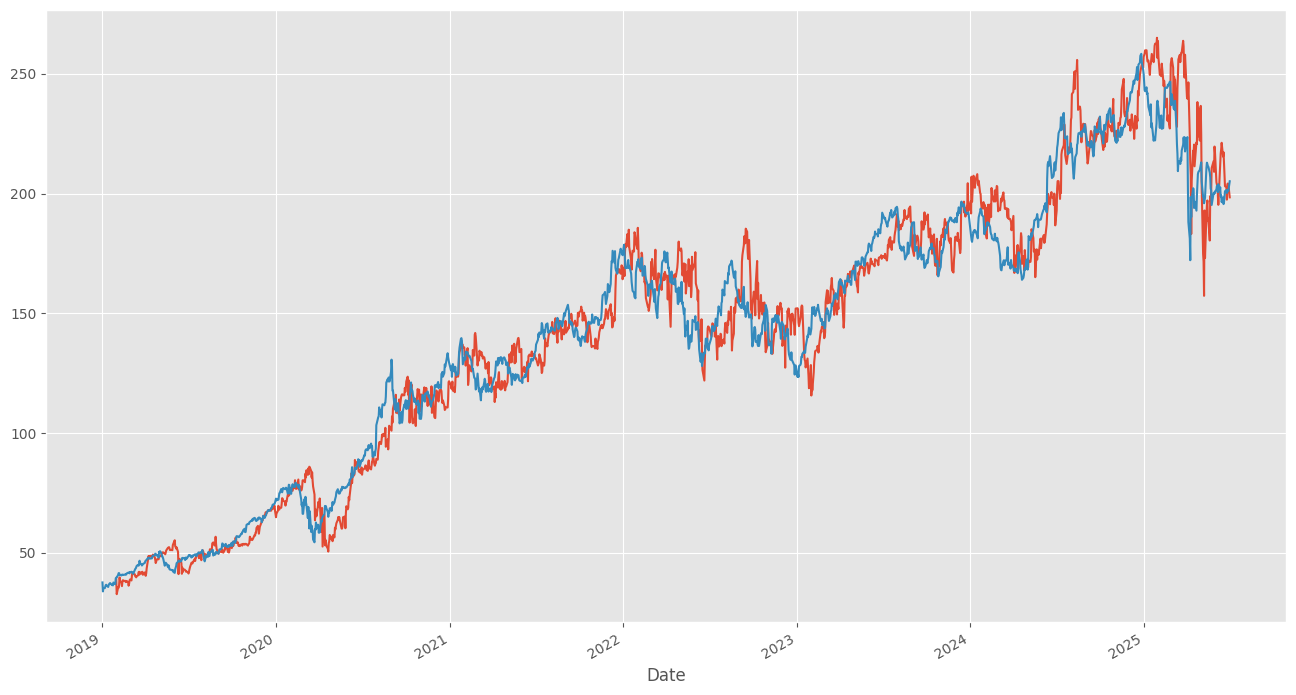

In [136]:
other_pred = (data/(1+experiment.predictions)).shift(lookahead)
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl

mpl.rc('figure', figsize=(16, 9))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

def plot_series(series: list[pd.Series], start_date: str=None, end_date: str=None):
    for serie in series:
        serie[start_date:end_date].plot()

plot_series([preds, data], "2019-01-01", end_date)

In [134]:
def quick_oos_diagnostics(ds, ticker, pred_oos, lookahead, start, end):
    import pandas as pd
    P = ds.get_data(ticker, start, end).astype(float)

    # Alinea OOS con precios
    df = pd.DataFrame({"P": P, "pred": pred_oos}).dropna()

    L = lookahead

    # y_true: retorno futuro relativo (t -> t+L)
    df["y_true"] = (df["P"].shift(-L) - df["P"]) / df["P"]
    df = df.dropna()

    # Métricas en retornos (no precios reconstruidos)
    err = df["pred"] - df["y_true"]
    r2  = 1 - (err**2).sum() / ((df["y_true"] - df["y_true"].mean())**2).sum()
    mae = err.abs().mean()
    rmse = (err**2).mean()**0.5
    c_future = df["pred"].corr(df["y_true"])

    # Comparación con retorno pasado (sanity check)
    df["y_past"] = (df["P"] - df["P"].shift(L)) / df["P"].shift(L)
    c_past = df["pred"].corr(df["y_past"])

    # Serie de precio predicho para graficar (absoluto, alineado en t+L):
    df["P_hat_t+L"] = (df["P"] * (1.0 + df["pred"])).shift(L)
    abs_pred = df["P_hat_t+L"].dropna()

    stats = {
        "n": len(df),
        "MAE": float(mae),
        "RMSE": float(rmse),
        "R2": float(r2),
        "corr(pred, future)": float(c_future),
        "corr(pred, past)": float(c_past),
    }
    return stats, abs_pred
stats, abs_pred = quick_oos_diagnostics(
    ds,
    ticker,
    experiment.predictions,   # ← OOS concatenadas
    lookahead,
    start_date,
    end_date
)
print(stats)

{'n': 1612, 'MAE': 0.07736639930341907, 'RMSE': 0.09712444487217384, 'R2': -0.40374818622985575, 'corr(pred, future)': 0.05311995933981484, 'corr(pred, past)': -0.17431204301608266}
